## Variable Selection for Classifier that Predicts Death of Heart Failure Patients


## Introduction

Heart failure occurs when the damaged or weakened heart muscle is unbale to pump blood efficiently to meet body’s needs. Multiple researches found that the risk factors of heart failure include but not limited to high blood pressure, diabetes, and smoking (Inamdar & Inamdar, 2016). This leads to the question of which predictor(s) are useful in predicting a heart failure patient’s survival after some period of time given their information. To answer this question, we will build models to analyze the “Heart Failure Prediction” dataset that was collected by Ahmad et al. in 2017. There are 11 predictors in the dataset but only 10 will be used:

* Age (years)
* Anaemia status (binary)
* Blood creatinine phosphokinase level (mcg/L) 
* Diabetes status (binary)
* Ejection fraction (percentage of blood leaving the heart at each contraction)
* High blood pressure status (binary)
* Platelets level in blood (kiloplatelets/mL)
* Level of serum creatinine in blood (mg/dL)
* Level of serum sodium in blood (mEq/L)
* Sex (binary, 0 for female and 1 for male)
* Smoking status (binary)

## Preliminary Exploratory Data Analysis

In [101]:
# import libraries for R functions

library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [2]:
# load data from the web
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv"
original_data <- read_csv(url)
# original_data

Rows: 299 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (13): age, anaemia, creatinine_phosphokinase, diabetes, ejection_fractio...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [96]:
# turn binary variables into factors

original_data <- original_data |>
    mutate(anaemia = as_factor(anaemia),
          diabetes = as_factor(diabetes),
          high_blood_pressure = as_factor(high_blood_pressure),
          platelets_num_per_mL = platelets/1000,
          sex = as_factor(sex),
          smoking = as_factor(smoking),
          DEATH_EVENT = as_factor(DEATH_EVENT))

# man is 1 in sex, woman is 0 since the paper said 194 men and 105 women, filtering for sex == 1 gives as 194 rows

In [4]:
# split the data into training and testing sets

set.seed(1625)

# split the data for 75% training and 25% testing, roughly same ratio of survived to dead in both sets as the original
data_split <- initial_split(original_data, prop = 0.75, strata = DEATH_EVENT)
training_data <- training(data_split)
testing_data <- testing(data_split)

In [40]:
# finding summary data of the training set

# mean of numerical predictors among survived or dead patients

numerical_preds <- c("Age (years)", "Creatinine phosphokinase (mcg/L)", "Ejection fraction (%)", "Platelet level (platelet/mL)", 
                     "Serum creatinine (mg/dL)", "Serum sodium (mEq/L)", "Follow-up period length (days)")

# make a function to find the mean of the numerical predictors among the survived patients
find_mean_survived <- function(dat) {
    
    result_list <- c()
    
    num_pred_only_data <- dat |> select(age, creatinine_phosphokinase, ejection_fraction, platelets_num_per_mL, 
                                        serum_creatinine, serum_sodium, time, DEATH_EVENT)
    
    for (i in 1:7) {
        
        curr_column <- num_pred_only_data[,i]
        death_event_column <- num_pred_only_data[,length(num_pred_only_data)]
        grouped_columns <- bind_cols(curr_column, death_event_column)
        as_tibble(grouped_columns)
        colnames(grouped_columns) <- c("Predictor", "Response")
        as_factor(grouped_columns$Response)
        
        result_list[i] <- mean(filter(grouped_columns, Response == 0)$Predictor, na.rm = TRUE)
        #mean_summary_dead[i] <- mean(filter(grouped_columns, Response == 1)$Predictor, na.rm = TRUE)
        
    }
    
    result_list
        
}


# make a function to find the mean of the numerical predictors among the dead patients
find_mean_dead <- function(dat) {
    
    result_list <- c()
    
    num_pred_only_data <- dat |> select(age, creatinine_phosphokinase, ejection_fraction, platelets_num_per_mL, 
                                        serum_creatinine, serum_sodium, time, DEATH_EVENT)
    
    for (i in 1:7) {
        
        curr_column <- num_pred_only_data[,i]
        death_event_column <- num_pred_only_data[,length(num_pred_only_data)]
        grouped_columns <- bind_cols(curr_column, death_event_column)
        as_tibble(grouped_columns)
        colnames(grouped_columns) <- c("Predictor", "Response")
        as_factor(grouped_columns$Response)
        
        result_list[i] <- mean(filter(grouped_columns, Response == 1)$Predictor, na.rm = TRUE)
        
    }
    
    result_list
        
}

# find the mean for each numerical predictors among the survived patients
mean_summary_survived <- find_mean_survived(training_data)

# find the mean for each numerical predictors among the dead patients
mean_summary_dead <- find_mean_dead(training_data)



# make a function to find the percentage of survived patients for each category of categorial variables

categorical_preds <- c("Anaemia", "No anameia", "Diabetes", "No diabetes", "High blood pressure", 
                       "No high blood pressure", "Male", "Female", "Smoker", "Non-smoker")


find_ratio_yes <- function(dat) {
    
    result_list <- c()
    
    categ_pred_only_data <- dat |> 
        select(anaemia, diabetes, high_blood_pressure, sex, smoking, DEATH_EVENT)
    
    for (i in 1:5) {
        
        curr_column <- categ_pred_only_data[,i]
        death_event_column <- categ_pred_only_data[,length(categ_pred_only_data)]
        grouped_columns <- bind_cols(curr_column, death_event_column)
        as_tibble(grouped_columns)
        
        colnames(grouped_columns) <- c("Predictor", "Response")
        
        as_factor(grouped_columns$Predictor)
        as_factor(grouped_columns$Response)
        
        
        filtered_response_yes <- filter(grouped_columns, Predictor == 1)[,2]

        number_survived_yes <- nrow(filter(filtered_response_yes, Response == 0))
        
        result_list[i] <- number_survived_yes/nrow(filtered_response_yes)*100
        
    }
    
    result_list
        
}



find_ratio_no <- function(dat) {
    
    result_list <- c()
    
    categ_pred_only_data <- dat |> 
        select(anaemia, diabetes, high_blood_pressure, sex, smoking, DEATH_EVENT)
    
    for (i in 1:5) {
        
        curr_column <- categ_pred_only_data[,i]
        death_event_column <- categ_pred_only_data[,length(categ_pred_only_data)]
        grouped_columns <- bind_cols(curr_column, death_event_column)
        as_tibble(grouped_columns)
        
        colnames(grouped_columns) <- c("Predictor", "Response")
        
        as_factor(grouped_columns$Predictor)
        as_factor(grouped_columns$Response)
        
        
        filtered_response_no <- filter(grouped_columns, Predictor == 0)[,2]

        number_survived_no <- nrow(filter(filtered_response_no, Response == 0))
        
        result_list[i] <- number_survived_no/nrow(filtered_response_no)*100
        
    }
    
    result_list
        
}

ratio_summary_yes <- find_ratio_yes(training_data)

ratio_summary_no <- find_ratio_no(training_data)

ratio_summary <- c(ratio_summary_yes[1], ratio_summary_no[1],
                   ratio_summary_yes[2], ratio_summary_no[2],
                   ratio_summary_yes[3], ratio_summary_no[3],
                   ratio_summary_yes[4], ratio_summary_no[4],
                   ratio_summary_yes[5], ratio_summary_no[5])


##### Summary Table 1. Mean of numerical predictors across survived and dead patients

In [97]:
# Create summary table 1
options(repr.matrix.max.rows = 10)
table_1 <- tibble(numerical_preds, round(mean_summary_survived, 4), round(mean_summary_dead, 4))
colnames(table_1) <- c("Predictor", "Mean predictor value among survived patients", "Mean predictor value among dead patients")
head(table_1, n = 10)

Predictor,Mean predictor value among survived patients,Mean predictor value among dead patients
<chr>,<dbl>,<dbl>
Age (years),59.2675,65.5232
Creatinine phosphokinase (mcg/L),521.2368,612.4583
Ejection fraction (%),40.4408,33.5694
Platelet level (platelet/mL),267.9566,255.1737
Serum creatinine (mg/dL),1.2170,1.8928
Serum sodium (mEq/L),136.8684,135.1389
Follow-up period length (days),164.6447,74.0139


In [7]:
# Create summary table 2
options(repr.matrix.max.rows = 10)
table_2 <- tibble(categorical_preds, round(ratio_summary, 4))
colnames(table_2) <- c("Predictor", "Percentage of survived patients")
head(table_2, 10)

Predictor,Percentage of survived patients
<chr>,<dbl>
Anaemia,62.3656
No anameia,71.7557
Diabetes,68.4783
No diabetes,67.4242
High blood pressure,61.3333
No high blood pressure,71.1409
Male,69.9301
Female,64.1975
Smoker,70.8333


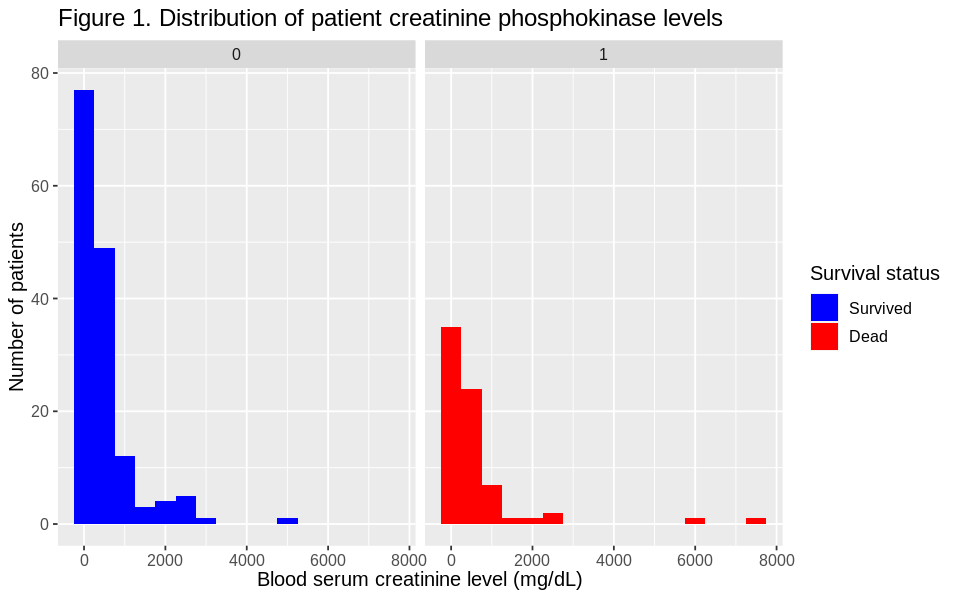

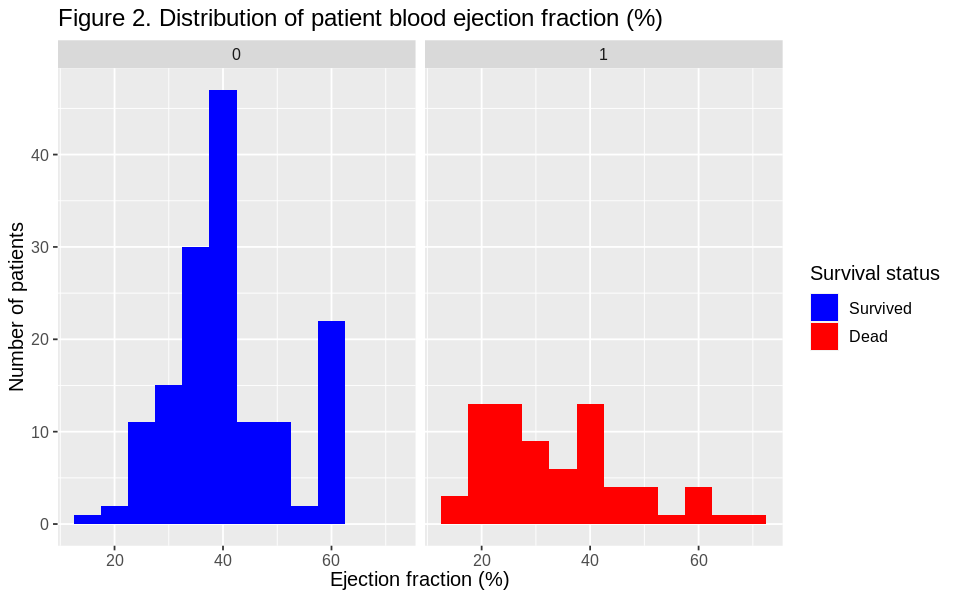

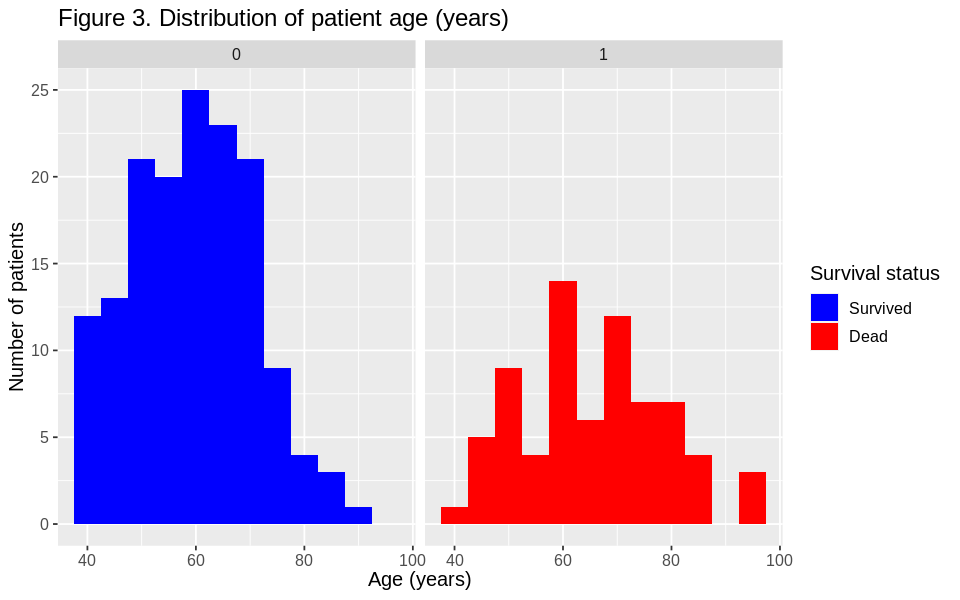

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



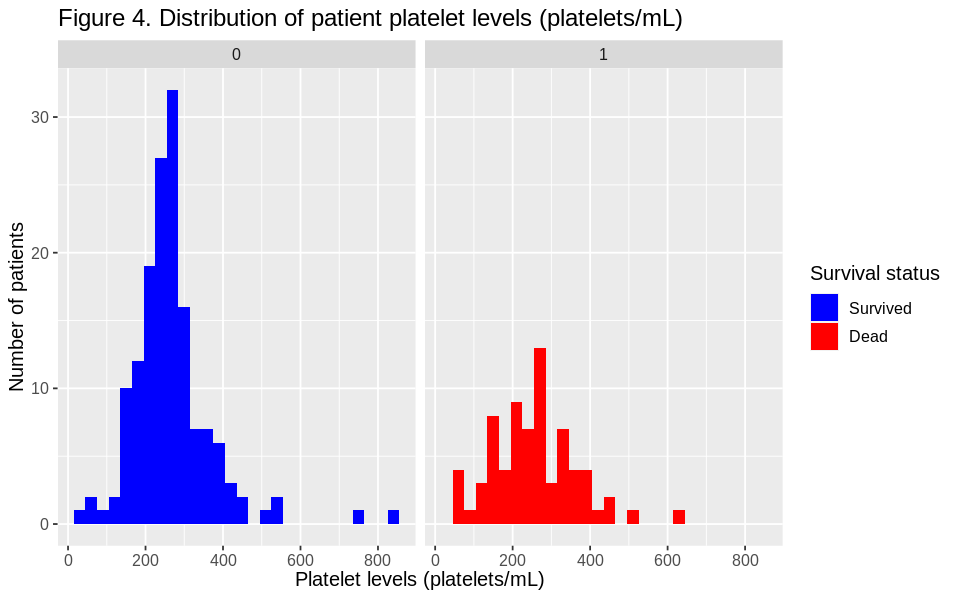

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



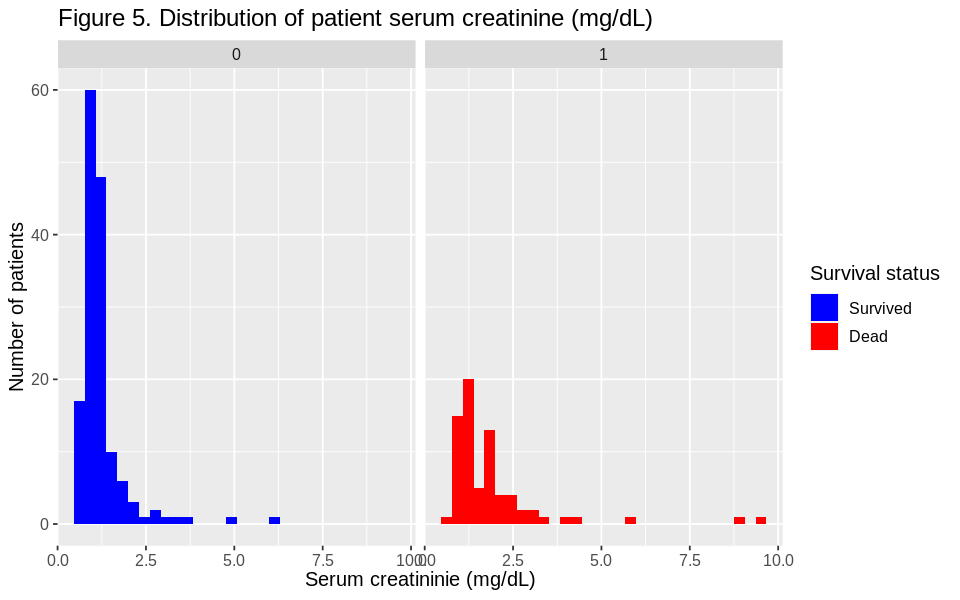

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



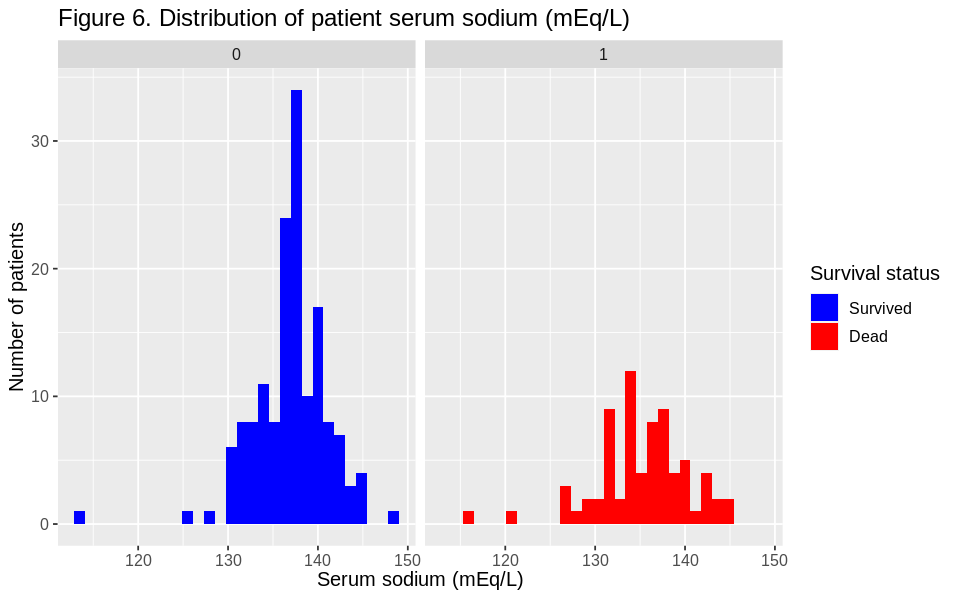

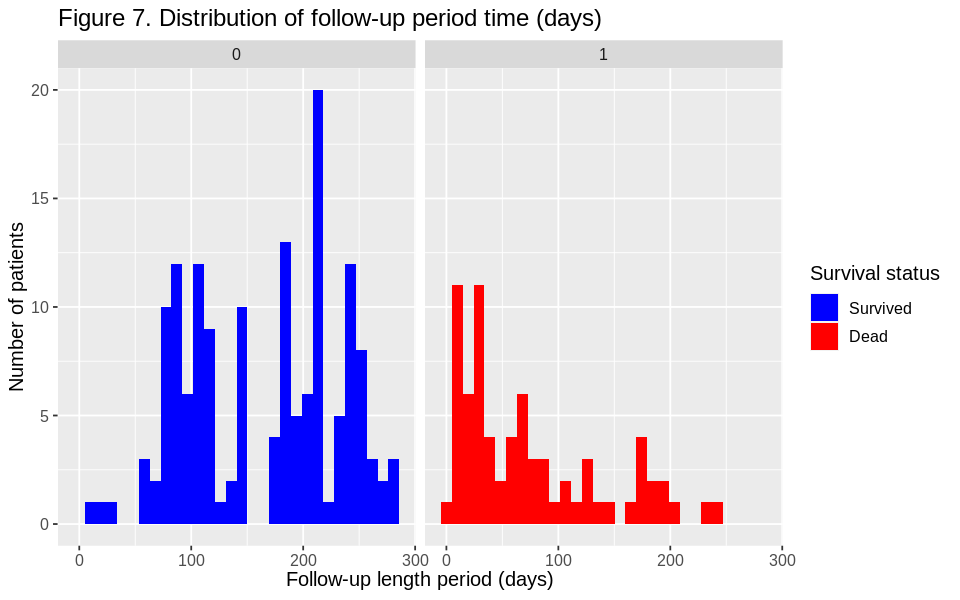

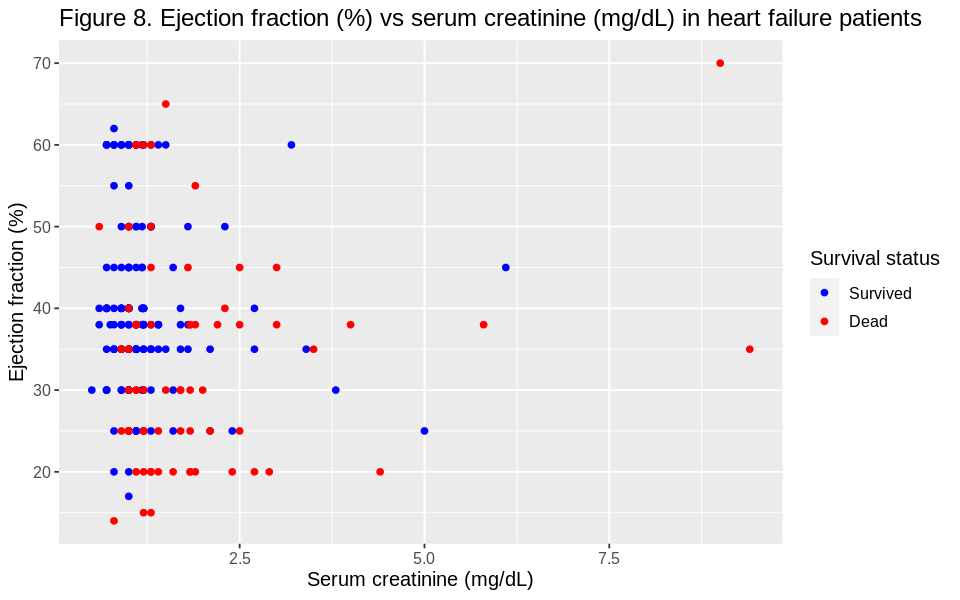

In [103]:
# Plots
options(repr.plot.height = 5, repr.plot.width = 8)

plot1 <- training_data |>
    ggplot(aes(x = creatinine_phosphokinase, fill = DEATH_EVENT)) +
    geom_histogram(binwidth = 500) +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Blood serum creatinine level (mg/dL)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 1. Distribution of patient creatinine phosphokinase levels") + 
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot1

plot2 <- training_data |>
    ggplot(aes(x = ejection_fraction, fill = DEATH_EVENT)) +
    geom_histogram(binwidth = 5) +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Ejection fraction (%)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 2. Distribution of patient blood ejection fraction (%)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot2

plot3 <- training_data |>
    ggplot(aes(x = age, fill = DEATH_EVENT)) +
    geom_histogram(binwidth = 5) +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Age (years)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 3. Distribution of patient age (years)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot3

plot4 <- training_data |>
    ggplot(aes(x = platelets_num_per_mL, fill = DEATH_EVENT)) +
    geom_histogram(binwidth = 30) +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Platelet levels (platelets/mL)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 4. Distribution of patient platelet levels (platelets/mL)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot4

plot5 <- training_data |>
    ggplot(aes(x = serum_creatinine, fill = DEATH_EVENT)) +
    geom_histogram() +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Serum creatininie (mg/dL)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 5. Distribution of patient serum creatinine (mg/dL)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot5

plot6 <- training_data |>
    ggplot(aes(x = serum_sodium, fill = DEATH_EVENT)) +
    geom_histogram() +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Serum sodium (mEq/L)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 6. Distribution of patient serum sodium (mEq/L)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot6

plot7 <- training_data |>
    ggplot(aes(x = time, fill = DEATH_EVENT)) +
    geom_histogram() +
    facet_grid(~DEATH_EVENT) +
    labs(x = "Follow-up length period (days)",
         y = "Number of patients",
         fill = "Survival status",
         title = "Figure 7. Distribution of follow-up period time (days)") +
    scale_fill_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot7

plot8 <- training_data |>
    ggplot(aes(x = serum_creatinine, y = ejection_fraction, color = DEATH_EVENT)) +
    geom_point() +
    labs(x = "Serum creatinine (mg/dL)",
         y = "Ejection fraction (%)",
         color = "Survival status",
         title = "Figure 8. Ejection fraction (%) vs serum creatinine (mg/dL) in heart failure patients") +
    scale_color_manual(labels = c("Survived", "Dead"), values = c("blue", "red")) +
    theme(text = element_text(size = 12))

plot8

## Methods

A k-nearest-neighbor classifier will be made to answer the proposed question. Most importantly, the variable time (follow-up period) will be excluded because it is different for each patient, and there were no details regarding the kind of follow-ups, which makes it harder to understand the role of this predictor. We acknowledge that this is a simplification, and that our model only predicts whether a patient will die or not after some finite time, but the amount of time does not matter. For variable selection, best subset selection will be attempted first, but if it ends up being non-feasible due to high volumes of computations, we would use forward selection which is less computationally costly. The selected classifier will then be trained with the best K-value found from cross-validation. 

During the process of building our model, visualising the result of each step would be crucial for analysing the result. We can achieve that by generating different charts using the ggplot function. For example, when choosing a k-value with the highest accuracy, we would apply cross-validation, and visualize the result (k-value verses accuracy) by geom_line() function.


## Expected Outcomes and Significance


#### Expected Outcomes:

From our summaries and past studies' findings, we expect our model to use not only serum creatinine and ejection fraction as predictors (Table 1, Fig. 1~8, Chicco & Jurman, 2020), but also the categorical variables that describe a patient’s gender, and statuses regarding anaemia, high blood pressure, and smoking because either the differences between their summary statistics (survived vs dead patients) for those variables are relatively greater or that past studies have found correlation between them and patient death (Table 2, Chairat et al., 2022, Ding et al., 2022, Romiti et al., 2022).


#### Significance:

The model could identify potential factors that correlate with heart failure mortality. From that, we could advocate for better living habits if lifestyle-related factors such as smoking is a major predictor for death of heart failure patients. In the case of biological factors such as serum creatinine levels being correlated with heart failure mortality, researchers could look into potential drug treatments that regulate their levels in patients’ bodies to prolong their lifespans. 

#### Future Directions:

The model for this project is merely predicting whether a heart failure patient will die or not based on some health information and the time factor is ignored for simplification. For future projects, a more impactful model we could work on is one that can predict the patient’s probability of survival after some specific amount of time given their current health information.
 

## References:

1. Ahmad, T., Munir, A., Bhatti, S. H., Aftab, M., & Raza, M. A. (2017). Survival analysis of heart failure patients: A case study. *PloS One, 12*(7), e0181001-e0181001. https://doi.org/10.1371/journal.pone.0181001

2. Chairat, K., Rattanavipanon, W., Tanyasaensook, K., Chindavijak, B., Chulavatnatol, S., & Nathisuwan, S. (2020). Relationship of anemia and clinical outcome in heart failure patients with preserved versus reduced ejection fraction in a rural area of Thailand. *International Journal of Cardiology. Heart & Vasculature*, 30, 100597-100597. https://doi.org/10.1016/j.ijcha.2020.100597.

3. Chicco, D., & Jurman, G. (2020). Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone. *BMC Medical Informatics and Decision Making, 20*(1), 16-16. https://doi.org/10.1186/s12911-020-1023-5

4. Ding, N., Shah, A. M., Blaha, M. J., Chang, P. P., Rosamond, W. D., & Matsushita, K. (2022). Cigarette smoking, cessation, and risk of heart failure with preserved and reduced ejection fraction. *Journal of the American College of Cardiology, 79*(23), 2298-2305. https://doi.org/10.1016/j.jacc.2022.03.377

5. Inamdar, A. A., & Inamdar, A. C. (2016). Heart Failure: Diagnosis, Management and Utilization. *Journal of Clinical Medicine, 5*(7), 62. https://doi.org/10.3390/jcm5070062

6. Romiti, G. F., Recchia, F., Zito, A., Visioli, G., Basili, S., & Raparelli, V. (2022, April 21). Sex and gender-related issues in heart failure. *Cardiology Clinics, 40*(2), 259-268. https://doi.org/10.1016/j.ccl.2021.12.013